In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import os
import matplotlib.image as img
import tqdm
import matplotlib.pyplot as plt 
from vae import Basic_VAE
from encoder import Encoder
from decoder import Decoder
from torch.utils.data import DataLoader, TensorDataset

#### Create Dataset


In [2]:
cats = []
directory = "data/cats"
count = 0

for catpic in os.listdir(directory):
    if count < 1000:
        # read from image and convert to tensor
        im = torch.tensor(img.imread(os.path.join(directory, catpic))).float()
        # permute to (channels, height, width) for conv2d layer
        im = torch.permute(im, (2, 0, 1))
        # normalize to range between -1 and 1
        im = im / 128 - 1
        cats.append(im)
        count += 1
    else:
        break
cats = torch.stack(cats)
print(cats.shape)

torch.Size([1000, 3, 64, 64])


#### Test/Training/Validation Split


In [3]:
# Split the data into what we use for testing and not testing
training_test_split = 0.75
training_test_cutoff = int(cats.shape[0] * training_test_split + 1)
random_perm = torch.randperm(cats.shape[0])
not_test_tensor = cats[:training_test_cutoff]
testing_tensor = cats[training_test_cutoff:]
# Split the data into what we use for training and cross validation
training_cv_split = 0.8
training_cv_cutoff = int(not_test_tensor.shape[0] * training_cv_split)
training_tensor = not_test_tensor[:training_cv_cutoff]
cv_tensor = not_test_tensor[training_cv_cutoff:]
print(training_tensor.shape)
print(cv_tensor.shape)
print(testing_tensor.shape)

torch.Size([600, 3, 64, 64])
torch.Size([151, 3, 64, 64])
torch.Size([249, 3, 64, 64])


#### Choose Hyperparameters and Build Model


In [4]:
from vae import Basic_VAE

hidden_dims = [16, 32, 64, 128]
latent_dim = 64
in_dim = 3
model = Basic_VAE(in_dim, hidden_dims, latent_dim)
# encoder = Encoder(in_dim, hidden_dims, latent_dim) for testing
# decoder = Decoder(latent_dim, hidden_dims) for testing

In [7]:
# # Testing the model
model.forward(training_tensor)
# # Code to test out the encoder & decoder
# mu, log_var = encoder.forward(training_tensor)
# print("mu: ", mu.shape)
# print("log_var: ", log_var.shape)

# reconstructed_img = decoder.forward(mu, log_var)

[tensor([[[[ 1.4794e-01, -5.5027e-01, -1.6522e-01,  ..., -1.8013e-01,
            -3.4475e-01, -1.2042e-01],
           [-5.3157e-01,  7.6096e-01,  7.0085e-01,  ...,  1.3680e-01,
             3.3449e-01, -6.0345e-01],
           [ 1.2834e-01,  1.8625e-01, -1.9629e-01,  ..., -5.0953e-01,
            -7.8324e-01,  4.7019e-01],
           ...,
           [-2.2373e-01, -6.1128e-01,  2.8522e-01,  ..., -3.7343e-01,
             7.8883e-02, -2.3463e-01],
           [-5.9115e-02,  1.9871e-01,  5.4364e-01,  ..., -2.2847e-01,
             2.0574e-01, -2.0261e-01],
           [-2.6807e-01, -2.5620e-01, -3.9362e-01,  ..., -7.4707e-02,
             3.5775e-01, -8.4257e-02]],
 
          [[-6.3492e-02, -1.0382e-01, -1.3608e-01,  ..., -4.1715e-01,
             4.2429e-01, -1.3828e-01],
           [-5.4051e-01,  5.5403e-01, -3.6123e-01,  ..., -5.5715e-01,
             8.5589e-01, -4.3946e-02],
           [-5.6086e-01,  1.5324e-01,  2.2126e-01,  ..., -4.8755e-02,
             3.4364e-02,  1.1861e-01],


#### Implement Loss Function


In [8]:
def loss_function(reconstructed_img, input_img, mu, log_var, kld_weight=2):
    # print("reconstructed_img: ", reconstructed_img.shape)
    # print("input_img: ", input_img.shape)
    img_loss = F.mse_loss(reconstructed_img, input_img)
    # article on calculating kl divergence between 2 gaussians:
    # https://medium.com/@outerrencedl/variational-autoencoder-and-a-bit-kl-divergence-with-pytorch-ce04fd55d0d7
    kld_loss = torch.mean(
        torch.sum(-log_var + (log_var.exp() ** 2 + mu**2) / 2 - 1 / 2)
        
    )
    # kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()))
    kld_loss *= kld_weight

    return img_loss + kld_loss

#### Implement Gradient Descent


In [9]:
def gradient_descent(model, loss_func, x, y, xvalid, yvalid, lr=0.1, steps=5000, batch_size=32):
    # only really need x or y, they are the same thing
    optimizer = optim.AdamW(model.parameters(), lr)

    losses = []
    valid_losses = []

    train_dataset = TensorDataset(x, y)
    train_batches = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    valid_dataset = TensorDataset(xvalid, yvalid)
    valid_batches = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    for _ in tqdm.trange(steps):
        model.train()
        total_loss = 0

        for input_batch, label_batch in train_batches:
            reconstructed_img, mu, log_var = model(input_batch)
            # y is the original image I think? yeah
            loss = loss_func(reconstructed_img, label_batch, mu, log_var)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            optimizer.zero_grad()
        mean_loss = total_loss/len(train_batches)
        losses.append(mean_loss)

        model.eval()
        total_valid_loss = 0
        for input_valid_batch, label_valid_batch in valid_batches:
            reconstructed_img, mu, log_var = model(input_valid_batch)
            valid_loss = loss_func(reconstructed_img, label_valid_batch, mu, log_var)
            total_valid_loss += valid_loss.detach()
        mean_valid_loss = total_valid_loss/len(valid_batches)
        valid_losses.append(mean_valid_loss)

    print(f"Final training loss: {losses[-1]}")

    return losses, valid_losses

In [10]:
losses, valid_losses = gradient_descent(
    model, loss_function, training_tensor, training_tensor, cv_tensor, cv_tensor, steps=10, lr = 0.001
)

100%|██████████| 10/10 [00:18<00:00,  1.83s/it]

Final training loss: 4.180126252927278


In [11]:
torch.save(model.state_dict(), "saved_model")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 64])


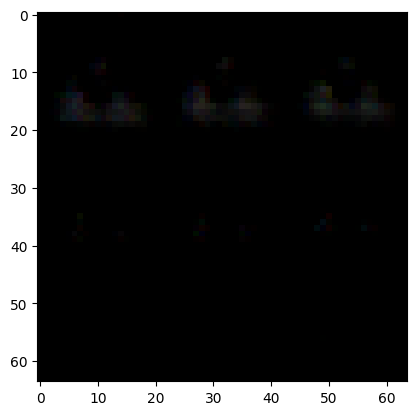

In [19]:
# after we've trained, we use the decoder to generate new images
# we assume a normal distribution over our latent space
# so we sample from that distribution and feed it into the decoder
img = model.sample_img()
img = img.view(64, 64, 3)
img = img.detach().numpy()
plt.imshow(img)